# Ques 3

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import copy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_recall_fscore_support

In [3]:
#to load fmnist, taken from: https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels



In [4]:
a, b = load_mnist('', kind='train')
c, d = load_mnist('', kind='t10k')

train_data=[]
train_labels=[]
test_data=[]
test_labels=[]

for i in range(len(b)):
    if(b[i]==1 or b[i]==2):          #trouser has class1 and pullover has class 2, we can drop the rest
        train_data.append(a[i])
        train_labels.append(b[i])
        
for i in range(len(d)):
    if(d[i]==1 or d[i]==2):   
        test_data.append(c[i])
        test_labels.append(d[i])
        
train_data=np.array(train_data)
train_labels=np.array(train_labels)
test_data=np.array(test_data)
test_labels=np.array(test_labels)


In [5]:
def binarize(threshold,train,test):
    for i in train:
        i[i<threshold]=0
        i[i>=threshold]=255
        
    for i in test:
        i[i<threshold]=0
        i[i>=threshold]=255
    return train,test

In [6]:
# train_data,test_data=binarize(128,train_data,test_data)

train_data=train_data/255
test_data=test_data/255


In [7]:
print(len(train_data))
print(len(train_labels))
print(len(test_data))
print(len(test_labels))

12000
12000
2000
2000


# Part 3.1

In [8]:
def log_gaussian(x,mean,var):
    if(var<1e-6):
        return 0
    return -(x-mean)**2/(2*(var**2))+np.log(1/(2*np.pi*(var**2)))/2
                  
def predict(mean,var,test_data):
    prediction=[]
    for i in range(len(test_data)):
        if(i%500==0):
            print("Tested "+str(i)+" samples.")
        sample=test_data[i]
        prob={}
        prob[1]=0
        prob[2]=0
        for j in range(len(sample)):
            prob[1]+=log_gaussian(sample[j],mean[1][j],var[1][j])
            prob[2]+=log_gaussian(sample[j],mean[2][j],var[2][j])
               
        if(prob[1]>prob[2]):
            prediction.append(1)
        else:
            prediction.append(2)
               
    prediction=np.array(prediction)
    return prediction

def naive_bayes(train_data,train_labels,test_data,test_labels):
    classwise={}
    for i in range(len(train_labels)):

        if train_labels[i] in classwise:
            classwise[train_labels[i]].append(train_data[i])
        else:
            classwise[train_labels[i]]=[]
            classwise[train_labels[i]].append(train_data[i])

    
    classwise[1]=np.array(classwise[1])
    classwise[2]=np.array(classwise[2])
    
    mean={}
    var={}
    mean[1]=np.mean(classwise[1],axis=0)
    mean[2]=np.mean(classwise[2],axis=0)
    var[1]=np.var(classwise[1],axis=0)
    var[2]=np.var(classwise[2],axis=0)
    
    prediction=[]
    for i in range(len(test_data)):
        if(i%500==0):
            print("Tested "+str(i)+" samples.")
        sample=test_data[i]
        prob={}
        prob[1]=0
        prob[2]=0
        for j in range(len(sample)):
            prob[1]+=log_gaussian(sample[j],mean[1][j],var[1][j])
            prob[2]+=log_gaussian(sample[j],mean[2][j],var[2][j])
               
        if(prob[1]>prob[2]):
            prediction.append(1)
        else:
            prediction.append(2)
               
    prediction=np.array(prediction)
    return mean,var,prediction

In [9]:
m,v,pred=naive_bayes(train_data,train_labels,test_data,test_labels)

Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.


In [10]:
def get_accuracy(pred,labels):
    correct=0
    for i in range(len(pred)):
        if(pred[i]==labels[i]):
            correct+=1
    
    accuracy=100*correct/len(labels)
    
    return(accuracy)
def print_accuracy(accuracy):
    print("Accuracy is: "+str(accuracy)+' %')

In [11]:
print_accuracy(get_accuracy(test_labels,pred))

Accuracy is: 95.95 %


In [12]:
confusion_matrix(test_labels, pred)

array([[927,  73],
       [  8, 992]], dtype=int64)

# Part 3.2

In [13]:
def k_fold_cross_validation(k,train_data,train_labels,test_data,test_labels):
    folds=[]    #(contain starting and ending indices)
    fold_size=len(train_data)//k
    
    list_train = train_data.tolist()
    list_train_labels = train_labels.tolist()
    models={}
    
    for i in range(k):
        if(i==k-1):
            folds.append((i*fold_size,len(train_data)))
        else:
            folds.append((i*fold_size,(i+1)*fold_size))
    
    for i in range(len(folds)):
        cross_test=[]
        cross_test_labels=[]
        
        cross_train=[]
        cross_train_labels=[]
        s,e=folds[i]
        
        for k in range(s,e):
            cross_test.append(list_train[k])
            cross_test_labels.append(list_train_labels[k])
        
        
        
        for j in range(len(folds)):
            if(i!=j):
                st,ed=folds[j]
                
                for k in range(st,ed):
                    cross_train.append(list_train[k])
                    cross_train_labels.append(list_train_labels[k])
        
        
        
        cross_test=np.array(cross_test)
        cross_test_labels=np.array(cross_test_labels)
        cross_train=np.array(cross_train)
        cross_train_labels=np.array(cross_train_labels)
        print(len(cross_train))
        print(len(cross_test))
        
        mean,var,prediction=naive_bayes(cross_train,cross_train_labels,cross_test,cross_test_labels)
        
        print("Taking "+str(i+1)+" fold as test set")
        print_accuracy(get_accuracy(prediction,cross_test_labels))
        models[i]=(get_accuracy(prediction,cross_test_labels),mean,var)
    
    return models

In [14]:
models=k_fold_cross_validation(5,train_data,train_labels,test_data,test_labels)

9600
2400
Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.
Tested 2000 samples.
Taking 1 fold as test set
Accuracy is: 95.45833333333333 %
9600
2400
Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.
Tested 2000 samples.
Taking 2 fold as test set
Accuracy is: 96.875 %
9600
2400
Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.
Tested 2000 samples.
Taking 3 fold as test set
Accuracy is: 96.375 %
9600
2400
Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.
Tested 2000 samples.
Taking 4 fold as test set
Accuracy is: 97.625 %
9600
2400
Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.
Tested 2000 samples.
Taking 5 fold as test set
Accuracy is: 97.33333333333333 %


In [15]:
to_sort=[]
for i in models:
    to_sort.append((models[i][0],i))

to_sort=sorted(to_sort,reverse=True)
best_model=models[to_sort[0][1]]
final_predictionn=predict(best_model[1],best_model[2],test_data)

Tested 0 samples.
Tested 500 samples.
Tested 1000 samples.
Tested 1500 samples.


# Part 3.3

In [29]:
print_accuracy(get_accuracy(final_predictionn,test_labels))
print(confusion_matrix(test_labels, final_predictionn))
print("Precision, recall, f1score is: ")
print(precision_recall_fscore_support(final_predictionn,test_labels))
print()

la,lb,lc=roc_curve(final_predictionn,test_labels,pos_label=2)

Accuracy is: 96.4 %
[[934  66]
 [  6 994]]
Precision, recall, f1score is: 
(array([0.934, 0.994]), array([0.99361702, 0.93773585]), array([0.9628866 , 0.96504854]), array([ 940, 1060], dtype=int64))

Roc curve: 


Roc curve: 


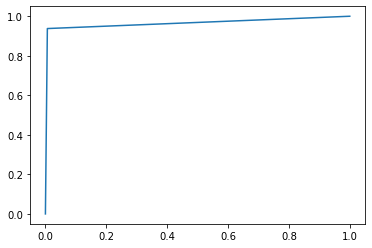

In [30]:
print("Roc curve: ")
plt.plot(la,lb)
plt.show()